# Generative Adversarial Networks

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from tqdm import tqdm

In [2]:
torch.manual_seed(42)
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# the commented parameters were used during actual training

# epochs = 40
epochs = 1
# batch_size = 512
batch_size = 128
lr = 2e-4  # learning rate

In [3]:
if not os.path.isdir('results'):
    os.makedirs('results')

if not os.path.isdir('generations'):
    os.makedirs('generations')

In [4]:
class Generator(nn.Module):

    def __init__(self, data_shape=(1, 28, 28), noise_shape=(100,)):
        super().__init__()
        
        self.noise_shape = noise_shape
        self.noise_dim = np.prod(noise_shape)
        
        self.data_shape = data_shape
        self.data_dim = np.prod(data_shape)

        self.generator = nn.Sequential(
            nn.Linear(self.noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.data_dim),
            nn.Tanh()  # Tanh if you normalize your data in [-1, 1]
        )

    def forward(self, noise):
        noise = noise.view(-1, self.noise_dim)
        return self.generator(noise).view(-1, *self.data_shape)

class Discriminator(nn.Module):

    def __init__(self, data_shape=(1, 28, 28)):
        super().__init__()
                
        self.data_shape = data_shape
        self.data_dim = np.prod(data_shape)

        self.discriminator = nn.Sequential(
                        nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),  # why sigmoid?
        )

    def forward(self, x):
        x = x.view(-1, *self.data_shape)
        return self.discriminator(x)


In [5]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Normalize in [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5])  # rescales range [0, 1] into [-1, 1]
])
train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [6]:
data_shape = (1, 28, 28)
noise_dim = 128

# models
gen = Generator(data_shape=data_shape, noise_shape=(noise_dim,)).to(device)
disc = Discriminator(data_shape=data_shape).to(device)

# two optimizers!
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr)
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr)  # typically good to use same learning rate for gen and disc

# loss function
loss_fn = nn.BCELoss()

## Minmax optimization

$$
\min_{G} \max_{D} \mathbb{E}_{x\sim p_{\text{data}}}[\log(D(x))] + \mathbb{E}_{z\sim p_{\text{noise}}}[\log(1-D(G(z)))]
$$

## Loss 

- real data $x$
- generated data $\hat{x}=G(z)$

$$
\mathcal{L}_{D} = -\sum_{i\in \text{batch}}\log(D(x_i)) - \sum_{i\in \text{batch}}\log(1-D(\hat{x}_i)) = \sum_{i\in \text{batch}}\text{BCE}(D(x_i), 1) + \sum_{i\in \text{batch}}\text{BCE}(D(\hat{x}_i), 0)
$$

$$
\mathcal{L}_{G} = \sum_{i\in \text{batch}}\log(1-D(\hat{x}_i))
$$

In practice, for the generator we use

$$
\mathcal{L}_{G} = -\sum_{i\in \text{batch}}\log(D(\hat{x}_i)) = \sum_{i\in \text{batch}}\text{BCE}(D(\hat{x}_i), 1)
$$

In [7]:
for epoch in range(epochs):
    for i, (x, _) in enumerate(tqdm(train_loader)):

        # Train discriminator
        opt_disc.zero_grad()

        x = x.to(device)
        z = torch.randn(x.shape[0], noise_dim)  # better use x.shape[0] instad of batch size
        z = z.to(device)
        x_hat = gen(z)

        target_real = torch.ones((x.shape[0], 1)).to(device)  # we want the disc to predict 1 for real samples
        target_fake = torch.zeros((x.shape[0], 1)).to(device)
        pred_real = disc(x)
        pred_fake = disc(x_hat)
        loss_real = loss_fn(pred_real, target_real)
        loss_fake = loss_fn(pred_fake, target_fake)
        loss_disc = (loss_real + loss_fake) / 2
        loss_disc.backward()
        opt_disc.step()

        # Train generator
        z = torch.randn(x.shape[0], noise_dim)
        z = z.to(device)
        x_hat = gen(z)
        
        target_real = torch.ones((x.shape[0], 1)).to(device)
        pred_fake = disc(x_hat)
        loss_gen = loss_fn(pred_fake, target_real)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # GANs train more slowly than other models, better train every 100 iters instead than every epoch
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss D: {loss_disc.item():.4f}, Loss G: {loss_gen.item():.4f}")


 21%|██▏       | 100/469 [00:37<02:19,  2.65it/s]

Epoch [1/1], Step [100/469], Loss D: 0.3021, Loss G: 4.6882


 43%|████▎     | 200/469 [01:16<02:05,  2.14it/s]

Epoch [1/1], Step [200/469], Loss D: 0.1024, Loss G: 6.3278


 50%|█████     | 235/469 [01:30<01:29,  2.60it/s]


KeyboardInterrupt: 

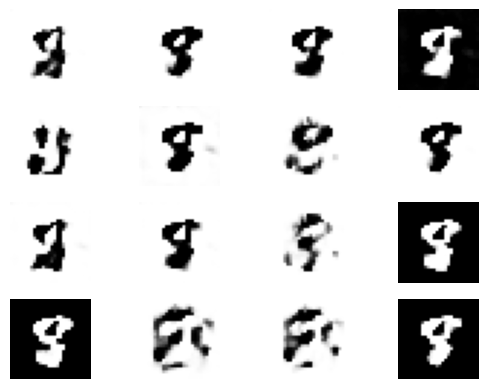

In [8]:

noise = torch.randn(16, noise_dim)
noise = noise.to(device)
x_hat = gen(noise)
generated_images = x_hat.detach().cpu().numpy().reshape(-1, 28, 28)

plt.figure()

for i, img in enumerate(generated_images):
    plt.subplot(4, 4, i+1)
    plt.imshow(img, cmap='binary')
    plt.axis('off')

plt.draw()


In [ ]:
# torch.save(gen.state_dict(), f'saved_model/gen_basic.pt')
# torch.save(disc.state_dict(), f'saved_model/disc_basic.pt')